# RNN (LSTM) for predicting the sentiment of an IMDB Review
First section consists of all my imports
I will be using pytorch for this RNN

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# EDA
Explanatory Data Analysis

In [18]:
data = pd.read_csv(r'/Users/mohamed_omer/Downloads/IMDB Dataset.csv')

data.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [19]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Data Initialization
Initiatlizing the csv file of  the IMDB reviews dataset and removing all punctuation and replacing upper case letters with lower case ones.




Targeting the 'review' feature and the 'sentiment' as a label

In [2]:
def data_initialize():


    word_counts = Counter()
    word_to_num={}
    tokenized_reviews=[]

    for review in data['review']:
        review = review.lower()
        review = ''.join(char for char in review if char.isalpha() or char.isspace() )
        words = review.split()
        word_counts.update(words)



    most_common= word_counts.most_common(5000)


    for i, (word,_) in  enumerate(most_common):
            word_to_num[word]=i + 2

    word_to_num['<PAD>'] = 0  # padding token
    word_to_num['<UNK>'] = 1  # unknown token


    for review in data['review']:
        temp=[]
        review = review.lower()
        review = ''.join(char for char in review if char.isalpha() or char.isspace() )
        review = review.split()

        review = review[:500]

        for word in review:
            temp.append(word_to_num.get(word, 1))

        tokenized_reviews.append(temp)


    vocab_size = len(word_to_num)

    review_tensors = [torch.tensor(r, dtype=torch.long) for r in tokenized_reviews]
    tensor_input_train = pad_sequence(review_tensors, batch_first=True, padding_value=0)

    labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
    labels_tensor = torch.tensor(labels.values, dtype=torch.long)

    return vocab_size, tokenized_reviews, tensor_input_train, labels_tensor

# RNN CLASS

Consists of the contructors that sets up embedding and the lstm module as well as the linear module.


A forward function that does all the forward propagation using PyTorch methods

In [19]:

class RNN(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,100)
        self.lstm = nn.LSTM(100,128,batch_first=True)
        self.linear = nn.Linear(128,1)



    def forward(self, tensor_input):
        embedded_input = self.embedding(tensor_input)
        lstm_output, (hidden_state, cell_state)=self.lstm(embedded_input)
        pooled = lstm_output.mean(dim=1)
        out = self.linear(pooled)

        return out

# Training Function
This function sets up the training data and splits it in batches and then iterates through them x (epochs) amount of times printing the loss each epoch and then saving the state dictionary as a .pth file

In [4]:
def training(myrnn, tokenized_reviews, tensor_input_train,labels_tensor,num_epochs):
    tensor_input_train = tensor_input_train[:4000]
    labels_tensor = labels_tensor[:4000]

    train_dataset = TensorDataset(tensor_input_train, labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


    Optimizer = optim.Adam(myrnn.parameters(),lr=0.001)
    Criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        for batch_data,batch_labels in train_loader:
            Optimizer.zero_grad()
            outputs = myrnn(batch_data).squeeze()
            loss = Criterion(outputs, batch_labels.float())
            loss.backward()
            Optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    torch.save(myrnn.state_dict(), 'model.pth')
    print("Model saved as model.pth")

# Testing function
This function loads the testing input and labels,  and then gets predictions for the test data and uses matplotlib to print a confusion matrix

In [5]:

def testing(model, tensor_input_train, labels_tensor):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Load the original data to get sentences
    data = pd.read_csv('IMDB Dataset.csv')

    model.load_state_dict(torch.load('model.pth'))
    print("Model loaded from model.pth")

    # Use last 1000 samples as test data
    test_input = tensor_input_train[4000:5000]
    test_labels = labels_tensor[4000:5000]


    with torch.no_grad():
        outputs = model(test_input).squeeze()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        accuracy = (predictions == test_labels.float()).sum().item() / len(test_labels)

    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_labels.numpy(), predictions.numpy())

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Show 3 examples
    print("\n=== EXAMPLES ===")
    for i in range(3):
        sentence = data.iloc[4000 + i]['review'][:200] + "..."
        actual = "Positive" if test_labels[i] == 1 else "Negative"
        guess = "Positive" if predictions[i] == 1 else "Negative"
        prob = torch.sigmoid(outputs[i]).item()

        print(f"Example {i+1}:")
        print(f"  Review: {sentence}")
        print(f"  Actual: {actual}")
        print(f"  Guess: {guess} ({prob:.3f})")
        print()

    return accuracy


# Main Function
This main function sets the epochs and calls all the functions needed to setup and test the RNN



Theres an area thats commented out because I tried to give a choice between test and train but I realized its much simpler to do both

Epoch 1/12, Loss: 0.6968
Epoch 2/12, Loss: 0.5669
Epoch 3/12, Loss: 0.4901
Epoch 4/12, Loss: 0.3961
Epoch 5/12, Loss: 0.2563
Epoch 6/12, Loss: 0.3654
Epoch 7/12, Loss: 0.2545
Epoch 8/12, Loss: 0.2054
Epoch 9/12, Loss: 0.1198
Epoch 10/12, Loss: 0.0596
Epoch 11/12, Loss: 0.2122
Epoch 12/12, Loss: 0.0864
Model saved as model.pth
Model loaded from model.pth
Test Accuracy: 0.8470


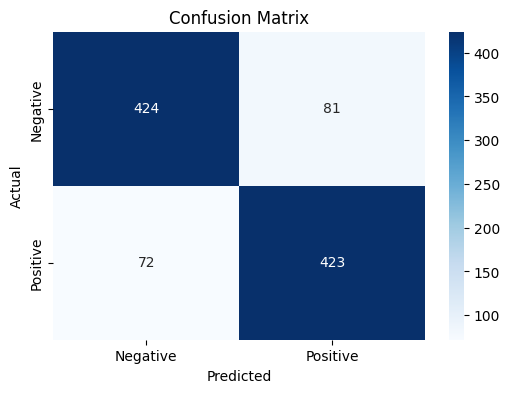


=== EXAMPLES ===
Example 1:
  Review: This feels as if it is a Czech version of Pearl Harbor. It has a same story, both guys fall in love with the same woman. And add to the twist, the woman is actually a married one whose husband has bee...
  Actual: Positive
  Guess: Positive (0.971)

Example 2:
  Review: When, oh, when will someone like Anchor Bay or Blue Underground release this on widescreen DVD??? Le Orme, which I only know because of my rare/vintage video collecting habit, is a film in my collecti...
  Actual: Positive
  Guess: Positive (0.999)

Example 3:
  Review: "Just before dawn " is one of the best slasher films.It very realistic and atmospheric.It reminds me Tobe Hooper`s "The Texas chainsaw massacre " and "Deliverance ".Deborah Benson very good plays the ...
  Actual: Positive
  Guess: Positive (0.997)



In [6]:

def main():
    epochs=12
    vocab_size, tokenized_reviews, tensor_input_train,labels_tensor = data_initialize()
    myrnn=RNN(vocab_size)
    # choice = input("choose train/test:")
    # if choice=="train":
    #     training(myrnn, tokenized_reviews, tensor_input_train,labels_tensor,epochs)
    # elif choice=="test":
    #     testing(myrnn,tensor_input_train,labels_tensor)
    # else:
    #     print("invalid choice")

    training(myrnn, tokenized_reviews, tensor_input_train,labels_tensor,epochs)
    testing(myrnn,tensor_input_train,labels_tensor)

main()